In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import re
import time

In [2]:
def get_stock_number_list():
    '''
    get stock number list from Taiwan Stock Exchange
    '''
    # fetch data from twse stock list
    list_url='https://www.twse.com.tw/zh/stockSearch/stockSearch'
    r= requests.get(list_url)
    soup= BeautifulSoup(r.content, 'html.parser')
    time.sleep(1)
    r.close()
    
    # find data and set up dataframe
    stock_html= soup.find_all('td')
    stock_list=[]
    for i in range(len(stock_html)):
        stock_list.append(stock_html[i].get_text())
    
    numbers= [s[:4] for s in stock_list] #extract stock number from list 
    names= [s[4:] for s in stock_list] # extract stock names from list
    
    stock_number_list= pd.DataFrame({'Numbers':numbers, 'Names':names})
    
    # replace blank row with NAN and drop it
    stock_number_list.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    stock_number_list.dropna(axis=0, inplace=True)
    # drop stock with '91' prefix
    dropstks= stock_number_list.Numbers.str.match(r'^91')
    stock_number_list.drop(stock_number_list[dropstks].index, inplace=True)
    
    return stock_number_list

In [3]:
stock_number_list= get_stock_number_list()
print(stock_number_list.head())
print(stock_number_list.shape)

  Numbers Names
0    1101    台泥
1    1102    亞泥
2    1103    嘉泥
3    1104    環泥
4    1108    幸福
(1034, 2)


In [86]:
stock_number_list[stock_number_list.Numbers=='9105']

,Numbers,Names
1004,9105,泰金寶-DR
1005,9105,05興業銅業
1006,9105,79歐聖


**每股盈餘年增率= [(本期每股盈餘 - 去年同期每股盈餘）/ 去年同期每股盈餘] * 100%**

In [4]:
stock_number= stock_number_list.Numbers.to_list()
stock_rows= len(stock_number)
print(stock_rows)

1034


In [5]:
eps_url= 'https://mopsfin.twse.com.tw'

In [6]:
driver= webdriver.Safari()
driver.get(eps_url)
time.sleep(1)

# set and click growth button
growth_button= driver.find_element_by_id("a-2")
growth_button.click()
time.sleep(1)

# set and click epsYOY button
epsYOY_button= driver.find_element_by_name("EPS")
epsYOY_button.click()
time.sleep(1)

# pre-warm output setting
block= driver.find_element_by_class_name('companyInput')
block.send_keys('2330')
avg_button= driver.find_element_by_id("displayBcodeAVG")
avg_button.click()
comavg_button= driver.find_element_by_id('displayCompanyAVG')
comavg_button.click()
compare_button= driver.find_element_by_class_name('button.solid.blue.compareBtn')
compare_button.click()
time.sleep(1)

In [7]:
# input stock number to search yearly eps
# check block number 
reset= driver.find_element_by_class_name("button.white.btn-setting.company-setting")
reset.click()
blocks= driver.find_elements_by_class_name('companyInput')
l= np.ceil(stock_rows/len(blocks)).astype('int')
close= driver.find_element_by_class_name("close-button")
close.click()

# construct output dataframe
df= pd.DataFrame()

for i in range(l):
    # clear inputs
    reset= driver.find_element_by_class_name("button.white.btn-setting.company-setting")
    reset.click()
    time.sleep(0.5)
    clear= driver.find_element_by_class_name("button.solid.white.clearBtn.clearCompany")
    clear.click()
    time.sleep(0.5)
    
    st= i*10
    ed= i*10 +10
    n_input= len(stock_number[st:ed])
    n_blocks= driver.find_elements_by_class_name('companyInput')[:n_input]
    
    # send inputs
    for n, b in enumerate(n_blocks):
        b.send_keys(stock_number[st+n])
    compare_button= driver.find_element_by_class_name('button.solid.blue.compareBtn')
    compare_button.click()
    time.sleep(5)
    
    # prepare temporary empty lists
    numbers=[]
    industries=[]
    eps_qua=[]
    
    # get number of rows
    tablerows=driver.find_element_by_xpath('//*[@id="resultList1"]/tbody')
    rows= len(tablerows.find_elements_by_class_name('text-left'))
    
    # get names of columns
    cols=[]
    table= driver.find_element_by_xpath('//*[@id="resultList2"]/thead/tr')
    for c in table.find_elements_by_class_name('text-right'):
        cols.append(c.text)
    
    # get stock info
    for j in range(rows):
        # get stock industry
        label= driver.find_element_by_xpath('//*[@id="c' + str(j) + '"]/..//label')
        number= re.search('(\d+\w)', label.text).group(0)
        industry= re.search('(?<=\().+?(?=\))',label.text).group(0)
        numbers.append(number)
        industries.append(industry)
        # get stock eps
        eps_set=[]
        for k in range(len(cols)):
            eps= driver.find_element_by_xpath('//*[@id="resultList2"]/tbody/tr[' + str(j+1) + ']/td[' +str(k+1) + ']')
            eps_set.append(eps.text)
        eps_qua.append(eps_set)
        
    # construct df
    temp1= pd.DataFrame({'Number':numbers, 'Industry': industries})
    temp2= pd.DataFrame(data=eps_qua,  columns=cols, index=numbers)
    temp_df= temp1.merge(temp2, left_on='Number', right_index=True, how='inner')
    df= pd.concat([df, temp_df], ignore_index= True)
print(df.shape)
print(df.head())

(969, 39)
  Number Industry 2013Q1 2013Q2 2013Q3 2013Q4 2014Q1 2014Q2 2014Q3 2014Q4  \
0   1101   上市水泥工業   0.38    0.7   0.97   0.66    0.5   0.86   0.87    0.7   
1   1102   上市水泥工業    0.4   0.83   0.34   0.67   0.47   1.21   0.64   0.69   
2   1103   上市水泥工業   0.13  -0.05   0.29    1.6  -0.06   0.06   0.24   -0.2   
3   1104   上市水泥工業    0.3   0.56   0.39   0.59    0.4   0.73   0.58   0.56   
4   1108   上市水泥工業   0.17   0.11   0.14   0.02   0.18   0.37    0.2   0.18   

   ... 2019Q4 2020Q1 2020Q2 2020Q3 2020Q4 2021Q1 2021Q2 2021Q3 2021Q4 2022Q1  
0  ...   1.19   0.55   1.39    1.3   1.17   0.57   1.24   0.59   0.89    0.2  
1  ...   1.27   0.24   1.49   1.57    1.4   1.02   1.44   1.04    1.2      -  
2  ...  -0.29  -0.33   0.22   0.93   1.92   -0.2  -0.25   1.37   0.09  -0.12  
3  ...   0.67   0.07   0.66    0.6   0.58   0.35   0.46    0.3   0.55      -  
4  ...   0.11   0.23   0.33   0.24   0.16   0.13    0.2   0.09   0.23      -  

[5 rows x 39 columns]


In [8]:
driver.quit()

In [210]:
label= driver.find_element_by_xpath('//*[@id="c' + str(1) + '"]/..//label')
re.findall('(\d+\w)', label.text)
re.search('(?<=\().+?(?=\))',label.text).group(0)

'上市食品工業'

In [149]:
industries

['上市食品工業',
 '上市食品工業',
 '上市食品工業',
 '上市食品工業',
 '上市食品工業',
 '上市食品工業',
 '上市食品工業',
 '上市食品工業']

In [150]:
numbers

['1213', '1215', '1216', '1217', '1218', '1219', '1220', '1225']

In [159]:
s1= pd.DataFrame(data=eps_qua,  columns=cols, index=numbers)
s1

,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,...,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4
1213,0.17,-0.1,0.41,-0.16,0.07,-0.01,0.29,-0.14,0.22,0,...,-0.22,-0.13,-0.22,0.16,-0.11,-0.3,-0.24,-0.41,-0.71,-0.3
1215,0.31,0.06,0.7,0.88,0.87,0.78,0.69,0.95,0.72,0.42,...,1.15,1.95,0.87,1.74,2.02,1.55,1.45,1.46,1.07,1.08
1216,0.75,0.59,0.87,0.35,0.81,0.6,0.35,0.36,0.79,0.81,...,0.91,0.5,0.79,1.12,1.26,0.62,0.95,0.95,1.01,0.6
1217,0.04,-0.04,-0.17,-0.11,-0.28,-0.29,-0.08,-0.08,-0.13,-0.13,...,0.16,-0.1,0.05,0.1,0.36,-0.04,0.14,0.23,0.18,-0.14
1218,-0.01,0.06,0.17,-0.57,0.07,-0.06,0.21,-0.02,-0.03,-0.04,...,0.54,0.16,0.26,0.47,0.7,0.32,0.34,0.28,0.29,0.31
1219,-0.11,-0.04,0.02,0.21,0.14,0.03,0,0.26,0.07,-0.01,...,0.09,0.4,0.83,0.23,0.41,0.43,0.73,0.15,-0.09,0.21
1220,0.12,0.04,0.19,-0.03,0.12,0.11,0.1,-0.02,-0.01,0.17,...,0.26,0.25,0.09,0.3,0.31,0.32,0.37,0.32,0.16,0.15
1225,0.13,0.11,-0.05,0.13,0.18,0.01,-0.29,0.34,0.14,0.05,...,0.42,0.44,0.36,0.29,0.39,0.68,0.91,0.47,0.13,0.56


In [161]:
s2= pd.DataFrame({'Number':numbers, 'Industry': industries})
s2

,Number,Industry
0,1213,上市食品工業
1,1215,上市食品工業
2,1216,上市食品工業
3,1217,上市食品工業
4,1218,上市食品工業
5,1219,上市食品工業
6,1220,上市食品工業
7,1225,上市食品工業


In [168]:
s2.merge(s1, left_on='Number', right_index=True)

,Number,Industry,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,2014Q3,2014Q4,...,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4
0,1213,上市食品工業,0.17,-0.1,0.41,-0.16,0.07,-0.01,0.29,-0.14,...,-0.22,-0.13,-0.22,0.16,-0.11,-0.3,-0.24,-0.41,-0.71,-0.3
1,1215,上市食品工業,0.31,0.06,0.7,0.88,0.87,0.78,0.69,0.95,...,1.15,1.95,0.87,1.74,2.02,1.55,1.45,1.46,1.07,1.08
2,1216,上市食品工業,0.75,0.59,0.87,0.35,0.81,0.6,0.35,0.36,...,0.91,0.5,0.79,1.12,1.26,0.62,0.95,0.95,1.01,0.6
3,1217,上市食品工業,0.04,-0.04,-0.17,-0.11,-0.28,-0.29,-0.08,-0.08,...,0.16,-0.1,0.05,0.1,0.36,-0.04,0.14,0.23,0.18,-0.14
4,1218,上市食品工業,-0.01,0.06,0.17,-0.57,0.07,-0.06,0.21,-0.02,...,0.54,0.16,0.26,0.47,0.7,0.32,0.34,0.28,0.29,0.31
5,1219,上市食品工業,-0.11,-0.04,0.02,0.21,0.14,0.03,0,0.26,...,0.09,0.4,0.83,0.23,0.41,0.43,0.73,0.15,-0.09,0.21
6,1220,上市食品工業,0.12,0.04,0.19,-0.03,0.12,0.11,0.1,-0.02,...,0.26,0.25,0.09,0.3,0.31,0.32,0.37,0.32,0.16,0.15
7,1225,上市食品工業,0.13,0.11,-0.05,0.13,0.18,0.01,-0.29,0.34,...,0.42,0.44,0.36,0.29,0.39,0.68,0.91,0.47,0.13,0.56


In [161]:
len(industries)

229

In [140]:
'//*[@id="c'+ str(0) +'"]/..//label'

'//*[@id="c0"]/..//label'

In [157]:
for j in range(10):
        # get stock industry
        label= driver.find_element_by_xpath('//*[@id="c' + str(j) + '"]/..//label')
        industry= re.findall('(上\S+業)',label.text)
        print(industry,label.text)

['上市水泥工業'] 1101 台泥 (上市水泥工業)
['上市水泥工業'] 1102 亞泥 (上市水泥工業)
['上市水泥工業'] 1103 嘉泥 (上市水泥工業)
['上市水泥工業'] 1104 環泥 (上市水泥工業)
['上市水泥工業'] 1108 幸福 (上市水泥工業)
['上市水泥工業'] 1109 信大 (上市水泥工業)
['上市水泥工業'] 1110 東泥 (上市水泥工業)
['上市食品工業'] 1201 味全 (上市食品工業)
['上市食品工業'] 1203 味王 (上市食品工業)
['上市食品工業'] 1210 大成 (上市食品工業)


In [148]:
driver.find_element_by_xpath('//*[@id="c'+str(1)+'"]/..//label').text

'1102 亞泥 (上市水泥工業)'

In [149]:
'//*[@id="c'+str(1)+'"]/..//label'

'//*[@id="c1"]/..//label'

In [8]:
element= driver.find_elements_by_class_name('companyInput')

In [9]:
s=['2330','5880','2884','2885','2002','6026','','','','']

In [10]:
for i, e in enumerate(element):
    e.send_keys(s[i])

4test

In [32]:
industry_button= driver.find_element_by_xpath('//*[@id="c2"]/..//label')

In [33]:
industry_button.text

'2884 玉山金 (上市金融保險業)'

In [16]:
element= driver.find_element_by_class_name('companyInput')

In [17]:
element.send_keys('2331')

In [2]:
driver= webdriver.Safari()

In [3]:
web_url= 'https://www.twse.com.tw/zh/page/trading/exchange/STOCK_DAY.html'

In [4]:
driver.get(web_url)

In [6]:
year_select= Select(driver.find_element_by_name("yy"))

In [7]:
# select year
year_select.select_by_visible_text('民國 110 年')

In [8]:
mon_select= Select(driver.find_element_by_name("mm"))

In [9]:
# select month
mon_select.select_by_visible_text('02月')

In [10]:
# select stock number
num_input= driver.find_element_by_class_name("stock-code-autocomplete")
num_input.send_keys(2890)

In [11]:
# Send stock request
button= driver.find_element_by_class_name("button.search")
button.click()

In [12]:
html= driver.find_element_by_class_name("html")

In [13]:
url= html.get_attribute('href')
time.sleep(5)
driver.close()

In [15]:
r= requests.get(url)

In [16]:
soup= BeautifulSoup(r.content, 'html.parser')

In [17]:
f1= soup.find('thead')

In [71]:
type(f1)

bs4.element.Tag

In [75]:
sub1= f1.find('td')
f1.ge

<td>日期</td>

In [39]:
tag_fields= soup.select('thead tr td')

In [40]:
cols= []
for col in tag_fields:
    cols.append(col.get_text())
print(cols)

['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數']


In [41]:
tag_data= soup.select('tbody tr td')

In [42]:
n= len(cols)
m= int(len(tag_data)/n)
print(n, m)

9 13


In [43]:
pre_values=[]
values= []

for data in tag_data:
    pre_values.append(data.get_text())

for i in range(m):
    values.append(pre_values[i * n: (i+1) *n])
print(values[:1])

[['110/02/01', '15,774,851', '174,213,855', '10.95', '11.10', '10.95', '11.10', '+0.15', '3,658']]


In [44]:
df=pd.DataFrame(data=values, columns=cols)
print(df.head(2))

          日期        成交股數         成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
0  110/02/01  15,774,851  174,213,855  10.95  11.10  10.95  11.10  +0.15   
1  110/02/02  15,968,550  177,788,390  11.10  11.20  11.05  11.10   0.00   

    成交筆數  
0  3,658  
1  4,614  


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日期      13 non-null     object
 1   成交股數    13 non-null     object
 2   成交金額    13 non-null     object
 3   開盤價     13 non-null     object
 4   最高價     13 non-null     object
 5   最低價     13 non-null     object
 6   收盤價     13 non-null     object
 7   漲跌價差    13 non-null     object
 8   成交筆數    13 non-null     object
dtypes: object(9)
memory usage: 1.0+ KB


In [46]:
df['日期']= df['日期'].str.replace(str(110), str(110+1911))

In [47]:
remove_comma= lambda x: x.str.replace(',','')

In [48]:
df[['成交股數', '成交金額','成交筆數']]= df[['成交股數', '成交金額','成交筆數']].apply(remove_comma)

In [49]:
df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2021/02/01,15774851,174213855,10.95,11.10,10.95,11.10,+0.15,3658
1,2021/02/02,15968550,177788390,11.10,11.20,11.05,11.10,0.00,4614
2,2021/02/03,14320465,159159629,11.15,11.15,11.10,11.10,0.00,3325
3,2021/02/04,9014880,100384768,11.10,11.15,11.05,11.15,+0.05,1570
4,2021/02/05,22475020,250849062,11.15,11.25,11.10,11.20,+0.05,3126


In [50]:
dtypes= {'日期': 'datetime64', '成交股數': 'int',\
         '成交金額': 'int64', '開盤價':'float', \
         '最高價':'float', '最低價':'float', \
         '收盤價':'float', '漲跌價差':'float', '成交筆數':'int64'}

In [51]:
df= df.astype(dtypes)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      13 non-null     datetime64[ns]
 1   成交股數    13 non-null     int64         
 2   成交金額    13 non-null     int64         
 3   開盤價     13 non-null     float64       
 4   最高價     13 non-null     float64       
 5   最低價     13 non-null     float64       
 6   收盤價     13 non-null     float64       
 7   漲跌價差    13 non-null     float64       
 8   成交筆數    13 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 1.0 KB


In [58]:
df= df.set_index('日期')

In [59]:
df.head()

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
日期,,,,,,,,
2021-02-01,15774851,174213855,10.95,11.10,10.95,11.10,0.15,3658
2021-02-02,15968550,177788390,11.10,11.20,11.05,11.10,0.00,4614
2021-02-03,14320465,159159629,11.15,11.15,11.10,11.10,0.00,3325
2021-02-04,9014880,100384768,11.10,11.15,11.05,11.15,0.05,1570
2021-02-05,22475020,250849062,11.15,11.25,11.10,11.20,0.05,3126


In [53]:
from datetime import datetime

In [54]:
datetime.today().day

25

In [36]:
import yfinance
from datetime import datetime
import mplfinance as mpf

In [37]:
stock= yfinance.Ticker('5880.tw')

In [23]:
history= stock.history(period='3y')
print(history.head())

                 Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2019-04-29  16.670550  16.834791  16.670550  16.834791  11080413        0.0   
2019-04-30  16.875853  16.875853  16.711610  16.834791   9881325        0.0   
2019-05-02  16.793731  16.875853  16.752671  16.834791  11530737        0.0   
2019-05-03  16.834792  16.834792  16.752671  16.793732  14319070        0.0   
2019-05-06  16.711611  16.752672  16.506310  16.588430  14244616        0.0   

            Stock Splits  
Date                      
2019-04-29           0.0  
2019-04-30           0.0  
2019-05-02           0.0  
2019-05-03           0.0  
2019-05-06           0.0  


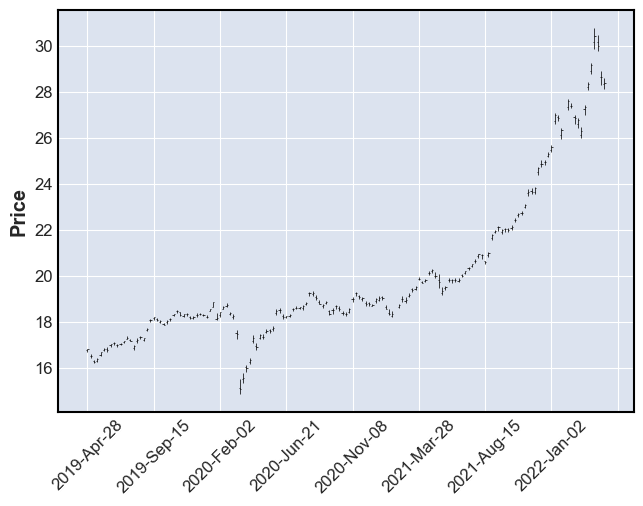

In [32]:
mpf.plot(history.resample('1W', label='left').mean())